# Prova d'esame - Laboratorio di calcolo e statistica
**5 febbraio 2024**

Si risolva il seguente esercizio, scrivendo un programma in C++ o in Python ed organizzando il codice
sorgente in modo che le funzioni utilizzate risultino implementate in librerie separate del programma
principale. Ai fini della valutazione, il primo criterio che deve essere soddisfatto è che il codice sia eseguibile senza errori (inclusi quelli di compilazione, nel caso del C++) realizzando le funzionalità richieste
dal testo. Per la valutazione sarà inoltre tenuto in considerazione il fatto che i codici sorgente siano scritti
con ordine, utilizzando opportunamente l’indentazione e i commenti. Per gli svolgimenti in C++, si
richiede infine di iniziare i codici con una riga di commento contenente il comando necessario per creare
l’eseguibile.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from iminuit import Minuit
from iminuit.cost import LeastSquares

Si definisca una funzione $\psi (x, a, b, c)$ che traccia un andamento parabolico in funzione di $x$ e se ne disegni disegni l’andamento nell’intervallo $(0, 10):\\ \psi(x, a, b, c) = a + bx + cx^2$

Funzioni per il programma principale

In [2]:
def parabola (x, a, b, c) :
    return a + b*x + c*(x**2)


# Funzione sturges per il binnaggio (funziona discretamente bene, ma conviene sempre veerificare)
def sturges (N_eventi) :
    return int (np.ceil (1 + np.log2 (N_eventi)))


# Distribuzione uniforme tra x_min e x_max con seed scelto in auto
def rand_range (x_min, x_max) :
    return x_min + random.random() * (x_max - x_min)


# Funzione che genera numeri pseudocasuali partendo dal teorema centrale del limite usando media, sigma di una gaussiana
# ed N numero di eventi pseudocasuali
def rand_TCL_par_gauss (mean, sigma, N) :           # par_gauss = parametri gaussiani
    y = 0. 
    xMin = mean - np.sqrt(3 * N) * sigma
    xMax = mean + np.sqrt(3 * N) * sigma
    for i in range (N) :
        y = y + rand_range (xMin, xMax)
    y /= N 
    return y 


def esegui_fit (x, y, sigma, dizionario_par, funzione_fit) :

    if not (isinstance(dizionario_par, dict)) :
        print ("Inserisci un dizionario come quarto parametro.\n")
        sys.exit()

    least_squares = LeastSquares (x, y, sigma, funzione_fit)
    my_minuit = Minuit (least_squares, **dizionario_par)
    my_minuit.migrad ()                                 
    my_minuit.hesse ()                                  

    is_valid = my_minuit.valid
    Q_squared = my_minuit.fval
    N_dof = my_minuit.ndof
    matrice_cov = my_minuit.covariance

    diz_risultati = {
        "Validità": is_valid, 
        "Qsquared": Q_squared,
        "Ndof": N_dof,
        "Param": my_minuit.parameters,
        "Value": my_minuit.values,
        "Errori": my_minuit.errors,
        "MatriceCovarianza": matrice_cov
    }

    return diz_risultati

Si generino $N = 10$ punti $x_i$ distribuiti in modo pseudo-casuale secondo una distribuzione uniforme
sull’intervallo orizziontale e si associ a ciascuno di essi una coordinata $y_i = \psi (x_i, a, b, c) + \epsilon_i$,
dove $\epsilon_i$ è un numero pseudo casuale generato, con il metodo del teorema centrale del limite, secondo
una distribuzione Gaussiana di media $0$ e deviazione standard $\sigma_y = 10$.

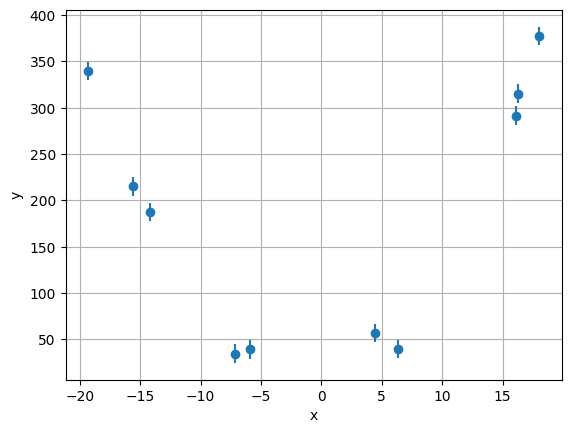

In [3]:
diz_para = {
    "a": 3.,
    "b": 2.,
    "c": 1.
}

N = 10
x = np.zeros (N)
y = np.zeros (N)
epsilon = np.zeros (N)
sigma = np.full (1, 10)

for i in range (N) :
    x[i] = rand_range (-20., 20.)
    epsilon[i] = rand_TCL_par_gauss (0., 10., 100)
    y[i] = parabola (x[i], **diz_para) + epsilon[i]

#print ("Fin qui tutto bene")

fig, ax = plt.subplots ()
ax.errorbar (x, y, xerr = 0.0, yerr = 10., linestyle = 'None', marker = 'o')
ax.set_xlabel ("x")
ax.set_ylabel ("y")
ax.grid ()

plt.show()

Si faccia un fit della funzione $\psi (x, a, b, c)$ sul campione così generato (che tecnica bisogna utilizzare?).


Esito del Fit:  True

Numero di gradi di libertà:  13.169300617754015

Valore del Q-quadro:  7.0 

Matrice di covarianza:
 ┌───┬───────────────────────────────┐
│   │         a         b         c │
├───┼───────────────────────────────┤
│ a │      30.7      0.04 -113.9e-3 │
│ b │      0.04    0.0552   -0.2e-3 │
│ c │ -113.9e-3   -0.2e-3  0.000628 │
└───┴───────────────────────────────┘
a = 8.011745 +/- 5.536286

b = 2.095484 +/- 0.234940

c = 1.002294 +/- 0.025058



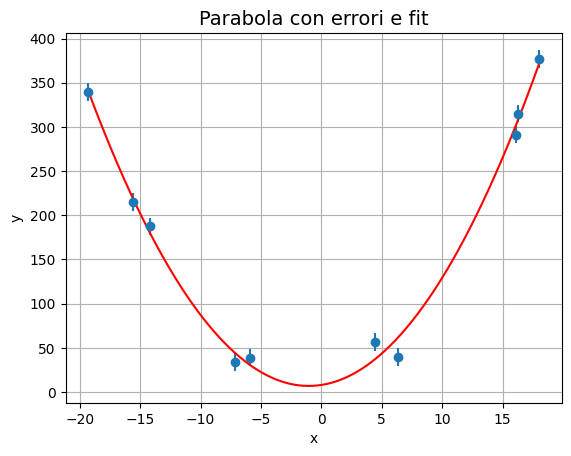


Per questo esercizio si è deciso di utilizzare il metodo dei minimi quadrat dato che i punti sono pochi
(la loglikelihood avrebbe dato dei bias)


In [4]:
diz_result = esegui_fit (x, y, sigma, diz_para, parabola)

print ("\nEsito del Fit: ", diz_result["Validità"])
print ("\nNumero di gradi di libertà: ", diz_result["Qsquared"])
print ("\nValore del Q-quadro: ", diz_result["Ndof"], "\n")
print("Matrice di covarianza:\n", diz_result["MatriceCovarianza"])

for param, value, errore in zip (diz_result["Param"], diz_result["Value"], diz_result["Errori"]) : 
    print (f'{param} = {value:.6f} +/- {errore:.6f}\n')

x_fit = np.linspace (min(x), max(x), 500)
y_fit = parabola (x_fit, *diz_result["Value"])

# grafico
fig, ax = plt.subplots ()
ax.set_title ('Parabola con errori e fit', size = 14)
ax.set_xlabel ('x')
ax.set_ylabel ('y')
ax.errorbar (x, y, xerr = 0.0, yerr = 10, linestyle = 'None', marker = 'o') 
ax.plot (x_fit, y_fit, color = 'red', label = 'Fit')
ax.grid ()

plt.show ()

print ("\nPer questo esercizio si è deciso di utilizzare il metodo dei minimi quadrat dato che i punti sono pochi\n(la loglikelihood avrebbe dato dei bias)")

Si costruisca la distribuzione del $Q^2$ a partire dal fit effettuato, ripetendolo molte volte utilizzando toy experiment.

In [8]:
lista_Q2 = []
N_toy = 100
for _ in range (N_toy) :
    for i in range (N) :
        x[i] = rand_range (-20., 20.)
        epsilon[i] = rand_TCL_par_gauss (0., 10., 100)
        y[i] = parabola (x[i], **diz_para) + epsilon[i]
    diz_result = esegui_fit (x, y, sigma, diz_para, parabola)
    lista_Q2.append (diz_result["Qsquared"])

#print (lista_Q2)

Si svolgano i punti precedenti generando gli scarti $\epsilon_i$ secondo una distribuzione uniforme che abbia la stessa deviazione standard della Gaussiana, disegnando poi la distribuzione del $Q^2$ così ottenuto sovrapposta a quella precedente (per una visualizzazione migliore, si può utilizzare l’opzione
$histtype=’step’$).

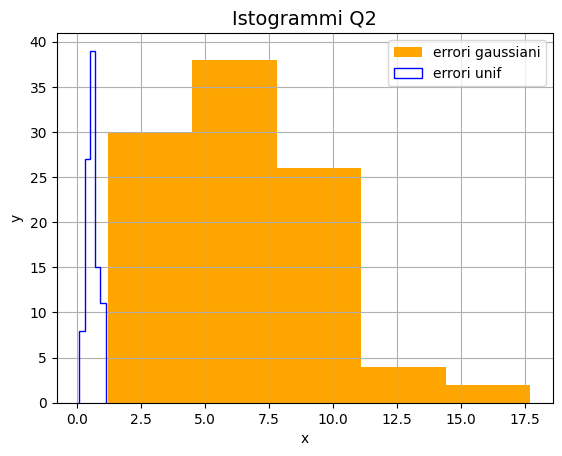

In [9]:
lista_Q2_unif = []
N_toy_unif = 100
for _ in range (N_toy_unif) :
    for i in range (N) :
        x[i] = rand_range (-20., 20.)
        epsilon[i] = rand_range (-10*np.sqrt(3), 10*np.sqrt(3))
        y[i] = parabola (x[i], **diz_para) + epsilon[i]
    diz_result = esegui_fit (x, y, sigma, diz_para, parabola)
    lista_Q2_unif.append (diz_result["Qsquared"])

#print (lista_Q2)

Nbin = sturges (N)

bin_content, bin_edges = np.histogram (lista_Q2, bins=Nbin, range = (min(lista_Q2), 
                                                                     max(lista_Q2)))      
bin_content_unif, bin_edges_unif = np.histogram (lista_Q2_unif, bins=Nbin, 
                                                 range = (min(lista_Q2_unif), 
                                                          max(lista_Q2_unif)))  

fig, ax = plt.subplots (nrows = 1, ncols = 1)
ax.hist (lista_Q2, bins=bin_edges, color = 'orange', label = 'errori gaussiani')
ax.hist (lista_Q2_unif, bins=bin_edges_unif, color = 'blue', histtype = 'step', label = 'errori unif')
ax.set_title ('Istogrammi Q2', size = 14)
ax.set_xlabel ('x')
ax.set_ylabel ('y')
ax.grid ()
ax.legend ()

plt.show () 